### In this notebook, we'll study about: **Handle Missing Values** 

1. Data Quality checks
2. Univariate Imputation using mean (BFILL, FFILL, FILLNA),
3. LOCF and NOCB 
4. Multivariate Imputation using Chained Equations
5. Linear Interpolation


## *Handling Missing Data*

* Obtaining a perfect clean dataset, in general, is too optimistic. What is more common is that the data you are working with suffers from flaws such as `missing values`, erroneous data, duplicate records, insufficient data, or the presence of outliers in the data.

* Time series data is no different, and before plugging the data into any analysis or modeling workflow, you must investigate the data first. Over the course of next few notebooks, we'll be looking at methods to relieve the suffering of such time series data. 

* This notebook explores different methods for identifying and handling missing data. You will learn different imputation and interpolation techniques. The notebook starts with simple statistical methods for univariate imputation and then explores various univariate interpolation algorithms for more advanced multivariate imputation.

### Business Context 
* It is vital to understand the `business context` around the time series data to detect and identify the above mentioned problems successfully. For example, 
if you work with `stock` data, the context is very different from `COVID` data or `sensor` data. 

* Having that intuition or domain knowledge will allow you to anticipate what to expect and what is considered acceptable when analyzing the data. Always try to understand the business context around the data. 
  
* For example, why is the data collected in the first place?  How was the data collected? What business rules, logic, or transformations have been 
applied to the data? Were these modifications applied during the data acquisition process or built into the systems that generate the data?

* For eg: If you're going through some stock data, and see that there is no price mentioned against the day Saturday & Sunday, that doesn't mean that it is a missing data. The case might be something else. We'd leave if to you to investigate. 

## Imputation & Interpolation
Missing data and 
outliers are two common problems that need to be dealt with during data cleaning and 
preparation. In this notebook, you will explore techniques to handle missing data through **imputation** and **interpolation**.  

Here is the list of methods that we will cover in this notebook:
* Performing data quality checks
* Handling missing data with univariate imputation using pandas
* Handling missing data with univariate imputation using scikit-learn
* Handling missing data with multivariate imputation
* Handling missing data with interpolation

# Technical Requirements
* In this notebook, two datasets will be used extensively for the imputation and interpolation methods: 
    * The CO2 Emissions dataset, and the e-Shop Clickstream dataset. 
    * The source for the Clickstream dataset comes from clickstream data for online shopping from the UCI machine learning repository, which you can find here: https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping
    * The source for the CO2 emissions dataset comes from the Annual CO2 emissions report from Our World in Data, which you can find here: https://ourworldindata.org/co2-emissions.

In [3]:
%pip install matplotlib numpy statsmodels scikit-learn scipy --quiet

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import numpy as np
import sklearn
import statsmodels as sm

print(f'''
pandas -> {pd.__version__}
numpy -> {np.__version__}
matplotlob -> {matplotlib.__version__}
statsmodels -> {sm.__version__}
scikit-learn -> {sklearn.__version__}
''')


pandas -> 1.4.2
numpy -> 1.21.5
matplotlob -> 3.5.1
statsmodels -> 0.13.2
scikit-learn -> 1.0.2



* For demonstration purposes, the two datasets have been modified by removing 
observations (missing data). The original versions are provided, in addition to the modified versions, to be used for evaluating the different techniques discussed in this notebook.

* You will follow similar steps for handling missing data: 
  * ingest the data into a DataFrame, 
  * identify missing data, 
  * impute missing data, 
  * evaluate it against the original data,
  * visualize and compare the different imputation techniques.

* These steps can be translated into functions for reusability. You can create functions for these steps in the process: 
  * a function to read the data into a DataFrame.
  * a function to evaluate using the RMSE score.
  * a function to plot the results. 

### Preparing for the methods of this notebook
Lets create the necessary functions - 

### Function 1 - `read_datesets()`
The `read_datasets` function takes a path to the folder, CSV filename, and the column name that contains the date variable. 

In [49]:
def read_dataset(folder, file, date_col=None):
    '''
    folder: is a Path object
    file: the CSV filename in that Path object. 
    date_col: specify a date_col to use as index_col 
    
    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df


### Function 2 - `plot_dfs()`
* The `plot_dfs()` function takes `two DataFrames`: the original DataFrame `(df1)` with no missing data (as the baseline), and the imputed DataFrame `(df2)` to compare against. 

* The function creates multiple time series subplots using the specified response column (col). Note that the imputed DataFrame will contain additional columns (a column for the output of each imputation technique), and the plotting function accommodates this fact. 

* This is done by looping through the columns. The function will plot each imputation technique for visual comparison and will be utilized throughout this notebook:

In [4]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''	
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    # subplots_size = df2.shape[1]
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0], figsize=(10, 16))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)

    plt.show()


### Function 3 - `rmse_score()`
* In addition to a `visual` comparison between imputation techniques using the `plot_dfs` function, you will need a method to compare the different imputation techniques numerically (using a statistical measure).

* This is where the `rmse_score function` will come in handy. It takes two DataFrames: the original DataFrame (df1) as the baseline and the imputed DataFrame (df2) to compare against. 

* The function allows you to specify which column contains the `response` column 
`(col)` used as the basis for the calculation.
 
The rmse_score function is defined as follows:

In [5]:
def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data

    returns: a list of scores
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores


## Understanding Missing Data: 
* We can discuss the inevitability of missing data in various scenarios, including power outages, defective sensors, and non-response from survey respondents, because we're well aware of it.
* While missing data is common, it is often not given the attention it deserves in terms of developing a strategy for handling it. 
* The first approach to handling missing data is to delete the rows, but this may not be ideal if data collection is complex and expensive, and it may result in missing out on valuable insights.
* A second approach is to tag missing data with labels that describe the cause of the missing data. 
* The third approach, which is the focus of this notebook, involves estimating missing data values using simple or complex techniques such as machine learning and statistical models. 
* I would emphasize the importance of thorough evaluation and validation when selecting an imputation technique to handle missing data. 
* The Root Mean Squared Error (RMSE) is used to evaluate different imputation techniques in the notebook. 
* RMSE is calculated by computing the difference between actual and estimated values, squaring the errors, summing them, and dividing by the total number of observations.

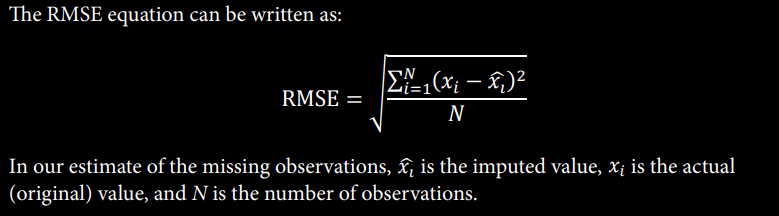

### RMSE for Evaluating Multiple Imputation Methods:
* I want to point out that RMSE is commonly used to measure the performance 
of predictive models (for example, comparing regression models). Generally, 
a lower RMSE is desirable; it tells us that the model can fit the dataset. 

* Simply stated, it tells us the average distance (error) between the predicted value and the actual value. You want this distance minimized. 
When comparing different imputation methods, we want our imputed values 
to resemble (as close as possible) the actual data, which contains random 
effects (uncertainty). 

* This means we are not seeking a perfect prediction, and 
thus a lower RMSE score does not necessarily indicate a better imputation 
method. Ideally, you would want to find a balance, hence, in this notebook, the 
use of RMSE is combined with visualization to help illustrate how the different techniques compare and work. 

```Reminder: we have intentionally removed some values (synthetically causing missing data) but retained the original data to compare against for when using RMSE.```

## Method 1: Perform Data Quality Checks

* Missing data are values not captured or observed in the dataset. Values can be missing 
for a particular feature (column), or an entire observation (row). When ingesting the data 
using pandas, missing values will show up as either NaN, NaT, or NA. 
* Sometimes, missing observations are replaced with other values in the source system; for 
example, this can be a numeric filler such as 99999 or 0, or a string such as missing
or N/A. When missing values are represented by 0, you need to be cautious and 
investigate further to determine whether those zero values are legitimate or they are 
indicative of missing data.

#### how to identify the presence of missing data?
* Examples of missing data
* Understand `NaN` vs `NaT`
* Identify missing observations that are replaced with other values in the source system but should be considered as missing
* Explain `na_values` and `keep_default_na` parameters 

In [12]:

co2 = Path('./data/co2_missing.csv')
ecom = Path('./data/clicks_missing_multiple.csv')
co2_df = pd.read_csv(co2, index_col='year', parse_dates=True)
ecom_df = pd.read_csv(ecom, index_col= 'date', parse_dates=True)

In [13]:
co2_df.shape

(226, 1)

In [15]:
ecom_df.shape

(135, 3)

In [16]:
ecom_df.head()

,price,location,clicks
date,,,
2008-04-01,43.155647,2.0,18784
2008-04-02,43.079056,1.0,24738
NaT,43.842609,NaN,15209
NaT,NaN,1.0,14018
NaT,43.941176,1.0,11974


The output from the preceding code shows that there are five missing values from 
the source dataset. NaN is how pandas represents empty numeric values (NaN is 
short for Not a Number). NaT is how pandas represents missing Datetime values 
(NaT is short for Not a Time)

In [17]:
co2_df.head()

,co2
year,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206


To count the number of missing values in both DataFrames, you can use the 
`DataFrame.isnull()` method. This will return `True` (if missing) or `False`
(if not missing) for each value. For example, to get the total count of missing values 
for each column, you can use `DataFrame.isnull().sum()`. 

Reminder: In Python, `Booleans (True or False)` are a subtype of integers. `True` is equivalent 
to `1`, and `False` is equivalent to `0`

In [18]:
co2_df.isnull().sum()

co2    25
dtype: int64

In [19]:
# using isna()
co2_df.isna().sum()

co2    25
dtype: int64

In [20]:
ecom_df.isna().sum()

price        1
location     1
clicks      14
dtype: int64

In [21]:
# using isnull()
ecom_df.isnull().sum()

price        1
location     1
clicks      14
dtype: int64

Notice in the preceding code that both `.isnull()` and `.isna()` were used. 
They both can be used interchangeably since `.isnull()` is an alias of `.isna()`.

From the results, `co2_df `has 25 missing values from the `co2` column, while 
`ecom_df` has 19 missing values in total (3 from the date column, 1 from the 
price column, 1 from the location column, and 14 from the clicks column).

To get the grand total for the entire ecom_df DataFrame, just chain another 
`.sum()` function to the end of the statement:

In [22]:
# using isnull()
ecom_df.isnull().sum().sum()

16

If you inspect the `co2_missing.csv` file using a text/code editor, Excel, 
or Jupyter (Notebook or Lab) and scroll down to rows `192-194`, you will notice that there are string placeholder values in there: NA, N/A, and null:

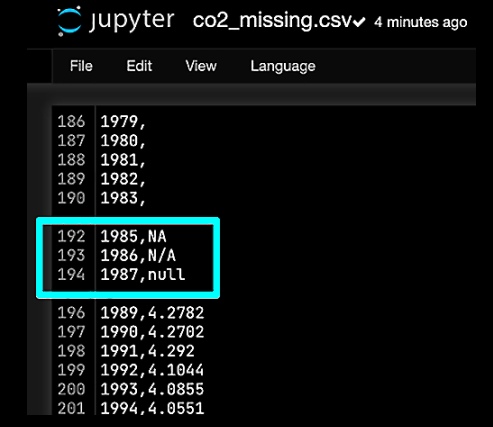

We can see three string values. Interestingly, `pandas.read_csv()`
interpreted the three string values as `NaN`. This is the default behavior in `read_csv()`, which can be modified through the `na_values` parameter. To see how 
pandas represents these values, you can run the following command:

In [16]:
co2_df[190:195]
# pandas.read_csv() interpreted the NA, N/A, and null strings as a NaN type

,co2
year,
1985-01-01,NaN
1986-01-01,NaN
1987-01-01,NaN
1988-01-01,4.2953
1989-01-01,4.2782


In [23]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2008-04-01 to 2008-08-13
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     134 non-null    float64
 1   location  134 non-null    float64
 2   clicks    121 non-null    object 
dtypes: float64(2), object(1)
memory usage: 4.2+ KB


If all you need is to check whether the DataFrame contains any missing values, use `isnull().values.any()`. This will output `True` if there are any missing values in the DataFrame:

In [24]:
ecom_df.isnull().values.any()

True

In [25]:
co2_df.isnull().values.any()

True

* So far, `.isnull()` helped identify all the missing values in the DataFrames. But what if the missing values were `masked` or replaced by other placeholder values such 
as `?` or `99999`. 

* The presence of these values will be skipped and considered missing 
`(NaN)` in pandas. Technically, they are not empty cells (missing) and hold values. 
* On the other hand, domain or prior knowledge will tell us that the CO2 emission 
dataset is measured annually and should have values greater than 0.

* Similarly, we expect the number of clicks to be numeric for the Clickstream data. If the column is not numeric, it should trigger an investigation as to why pandas 
could not parse the column as numeric. 

For example, this could be due to the 
presence of string values.

To gain a better insight into the DataFrame schema and data types, you can use 
`DataFrame.info()` to display the schema, total records, column names, column 
dtypes, count of non-missing values per column, index dtype, and the DataFrame's total memory usage:

In [26]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226 entries, 1750-01-01 to 2020-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     201 non-null    float64
dtypes: float64(1)
memory usage: 3.5 KB


The co2_df summary output looks reasonable, confirming that we have 25 
(226-221=25) missing values in the co2 column. 

In [27]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2008-04-01 to 2008-08-13
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     134 non-null    float64
 1   location  134 non-null    float64
 2   clicks    121 non-null    object 
dtypes: float64(2), object(1)
memory usage: 4.2+ KB


On the other hand, the summary for `ecom_df` indicates that the clicks column 
is of the `object` dtype, and not the expected `float64`. Let's investigate further 
using basic summary statistics.

use the `DataFrame.describe()`
method:

In [28]:
co2_df.describe(include='all')

,co2
count,201.000000
mean,1.590015
std,1.644182
min,0.000000
25%,0.076400
50%,0.935100
75%,2.807600
max,4.907900


* Note the use of include='all' to replace the default value None. The default 
behavior is to show summary statistics for only numeric columns. By changing the 
value to 'all', the results will include all column types. 

* The summary statistics for the co2_df DataFrame confirms that we have zero 
values (min = 0.00). As pointed out earlier, prior 
knowledge tells us that 0 represents a null (or missing) value. Therefore, the zeros 
will need to be replaced with NaN to include such values in the imputation process.

In [29]:
ecom_df.describe(include='all')

,price,location,clicks
count,134.000000,134.000000,121
unique,NaN,NaN,119
top,NaN,NaN,?
freq,NaN,NaN,2
mean,43.480221,1.694030,NaN
std,0.610578,1.118724,NaN
min,42.207018,1.000000,NaN
25%,43.038050,1.000000,NaN
50%,43.498842,1.000000,NaN
75%,43.889935,2.000000,NaN


* As you can see, the summary statistics for the ecom_df DataFrame indicate that 
we have a ? value under the clicks column. This explains why pandas did not 
parse the column as numeric (due to mixed types). Similarly, the ? values will need 
to be replaced with NaN to be treated as missing values for imputation.



In [30]:
test = pd.read_csv(ecom, parse_dates=['date'], na_values={'?'})
test

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784.0
1,2008-04-02,43.079056,1.0,24738.0
2,NaT,43.842609,NaN,15209.0
3,NaT,NaN,1.0,14018.0
4,NaT,43.941176,1.0,11974.0
...,...,...,...,...
130,2008-08-09,44.182033,1.0,6716.0
131,2008-08-10,43.608260,1.0,9523.0
132,2008-08-11,43.553363,1.0,8881.0
133,2008-08-12,44.500469,1.0,7272.0


In [31]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2008-04-01 to 2008-08-13
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     134 non-null    float64
 1   location  134 non-null    float64
 2   clicks    121 non-null    object 
dtypes: float64(2), object(1)
memory usage: 4.2+ KB


Convert the `0` and `?` values to `NaN` types. This can be accomplished using the 
`DataFrame.replace()` method:

In [32]:
co2_df.replace(0, np.NaN, inplace=True)
ecom_df.replace('?', np.NaN, inplace=True)
ecom_df['clicks'] = ecom_df['clicks'].astype('float')

To validate, run `.isnull().sum()` and you should notice that the missing value 
counts have increased:

In [33]:
co2_df.isnull().sum()

co2    35
dtype: int64

In [34]:
ecom_df.isnull().sum()

price        1
location     1
clicks      16
dtype: int64

The new numbers do a better job of reflecting the number of actual missing values in 
both DataFrames.

## How it works

* When reading the CSV files using `pandas.read_csv()`, the default behavior is to 
recognize and parse certain string values, such as `NA, N/A, and null`, to the NaN type 
(missing). Thus, once these values became `NaN`, the CSV reader could parse the co2
column as `float64 (numeric)` based on the remaining non-null values.

* This is possible due to two parameters: `na_values` and `keep_default_na`.
*  The `na_values` parameter, by default, contains a list of strings that are interpreted as NaN. The list includes `#N/A, #N/A N/A, #NA, -1.#IND, -1.#QNAN, -NaN, -nan, 1.#IND, 1.#QNAN, <NA>, N/A, NA, NULL, NaN, n/a, nan, and null.` 
You can append to this list by providing additional values to the na_values parameter. 
* Additionally, `keep_default_na` is set to True by default, thus using na_values with the default list for parsing.
* If you change `keep_default_na` to `False` without providing new values to `na_values`, then none of the strings `(NA, N/A, and null)` would be parsed to `NaN` unless 
you provide a custom list. For example, if `keep_default_na` was set to `False` and no 
values provided to na_values, then the entire co2 column would be parsed as 
a string (object), and any missing values will show up as strings; in other words, they 
will be coming in as '', which is an empty string.

In [35]:
co2_df = pd.read_csv(co2, keep_default_na=False)
co2_df.isna().sum()

year    0
co2     0
dtype: int64

In [36]:
co2_df.shape

(226, 2)

Notice that we did not lose any data (226 records) but showed no NaN (or missing) 
values. Let's inspect the DataFrame structure:

In [38]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    226 non-null    int64 
 1   co2     226 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.7+ KB


Notice the change in dtype for the co2 columns. Let's check the data from index 190 to 
195 again:

In [39]:
co2_df.iloc[132:139]

,year,co2
132,1927,
133,1928,
134,1929,
135,1930,
136,1931,
137,1932,
138,1933,


In [40]:
co2_df.iloc[132:139]['co2'] == ''

132    True
133    True
134    True
135    True
136    True
137    True
138    True
Name: co2, dtype: bool

You will notice all seven rows have blank values (empty string).

In this method you explored the `.isna()` method. Once the data is read into a DataFrame 
or series, you get access to the `.isna()` and `.isnull()` methods, which return `True`
if data is missing and `False` otherwise. To get the counts for each column, we just chain 
a `.sum()` function, and to get the grand total, we chain another .sum() function 
following that:

In [44]:
co2_df.isnull().sum()
co2_df.isnull().sum().sum()

0

### There is More

If you know that the data will always contain ?, which should be converted to NaN
(or any other value), then you can utilize the `pd.read_csv()` function and update the 
na_values parameter. This will reduce the number of steps needed to clean the data 
after creating the DataFrame:

In [45]:
pd.read_csv(ecom, parse_dates=['date'], na_values={'?'})

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784.0
1,2008-04-02,43.079056,1.0,24738.0
2,NaT,43.842609,NaN,15209.0
3,NaT,NaN,1.0,14018.0
4,NaT,43.941176,1.0,11974.0
...,...,...,...,...
130,2008-08-09,44.182033,1.0,6716.0
131,2008-08-10,43.608260,1.0,9523.0
132,2008-08-11,43.553363,1.0,8881.0
133,2008-08-12,44.500469,1.0,7272.0


This will replace all instances of ? with NaN.


In [46]:
pd.read_csv(ecom, parse_dates=['date'], na_values={'?'}).isna().sum()

date         4
price        1
location     1
clicks      16
dtype: int64

# Method 2: Handling Missing Data with Univariate Imputation using pandas  

Generally, there are two approaches to imputing missing data: `univariate imputation` and `multivariate imputation`. This method will explore univariate imputation techniques available in pandas.

In univariate imputation, you use non-missing values in a single variable (think a column 
or feature) to impute the missing values for that variable. For example, if you have a sales 
column in the dataset with some missing values, you can use a univariate imputation 
method to impute missing sales observations using average sales. Here, a single column 
(sales) was used to calculate the mean (from non-missing values) for imputation.

Some basic univariate imputation techniques include the following:
* Imputing using the **mean**.
* Imputing using the last observation forward (**forward fill**). This can be referred to as **Last Observation Carried Forward (LOCF)**.
* Imputing using the next observation backward (**backward fill**). This can be referred to as **Next Observation Carried Backward (NOCB)**.  

You will use two datasets to impute missing data using different techniques and then compare the results.

### How to do it?

You will start by importing the libraries and then read all four CSV files. You will use the 
original versions of datasets to compare the results of the imputations to gain a better 
intuition of how they perform. 

For the comparison measure, you will use RMSE to 
evaluate each technique and then visualize the outputs to compare the imputation 
results visually:

In [47]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [50]:
folder = Path('./data/')

co2_original = read_dataset(folder, 'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date')

In [51]:
co2_missing.isnull().sum()

co2    35
dtype: int64

In [52]:
clicks_missing.isnull().sum()

price        0
location     0
clicks      16
dtype: int64

In [53]:
clicks_missing.loc[:, 'missing':].shape[1]

2

Visualize the CO2 DataFrames (original and missing) and specify the column with 
missing values (co2):

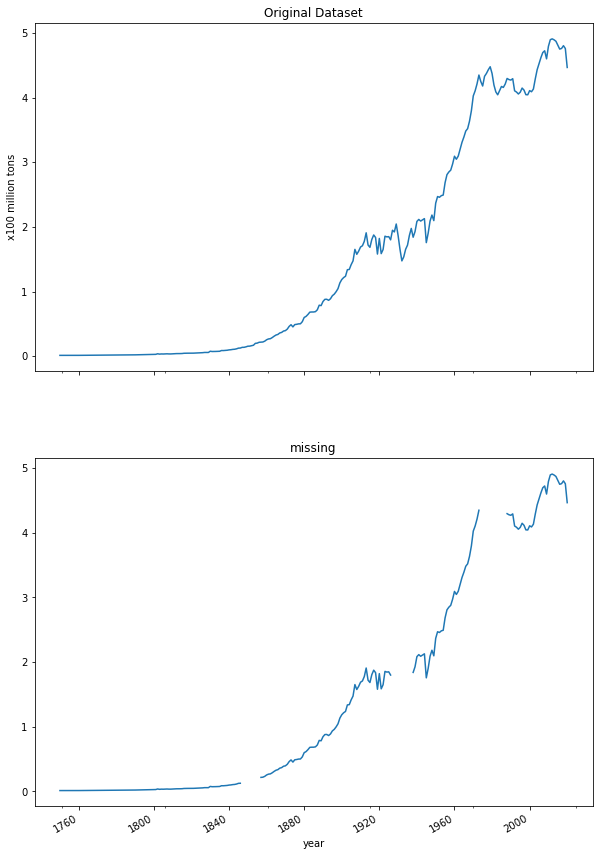

In [56]:
plot_dfs(co2_original, 
         co2_missing, 
         'co2',
         title="Annual CO2 Emission per Capita",
         xlabel="Years",
         ylabel="x100 million tons")

The plot_dfs function will produce two plots: the original CO2 dataset without 
missing values, and the altered dataset with missing values.
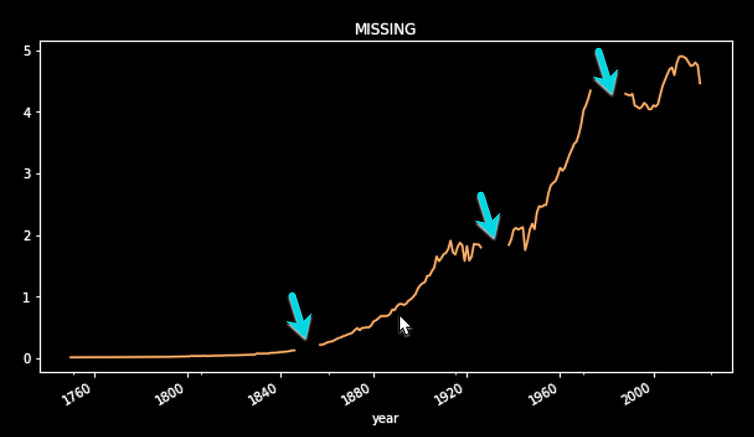

You can see a noticeable upward trend in CO2 levels 
over time. There is missing data in three different spots. 


Now, visualize the 
Clickstream DataFrames:

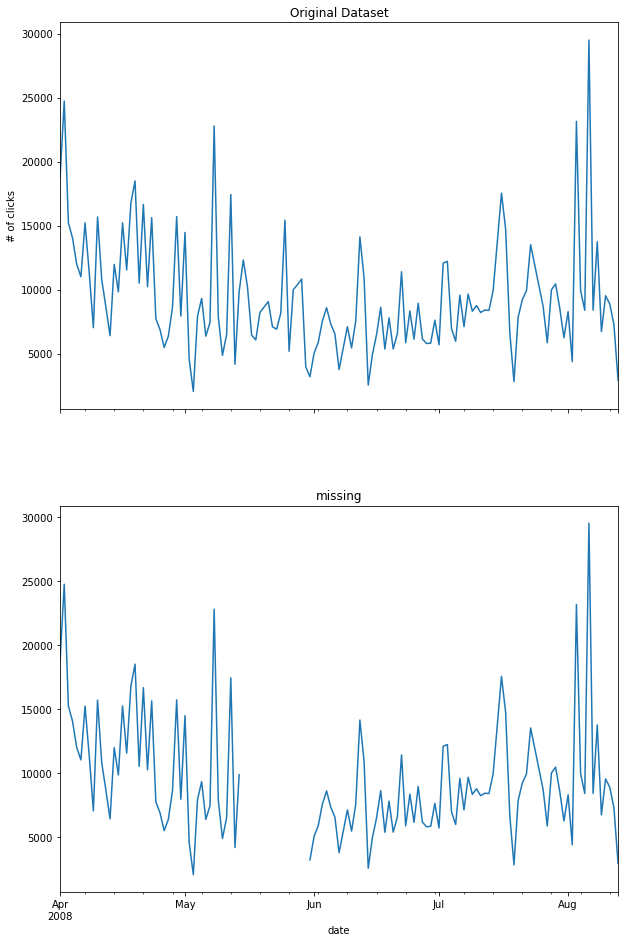

In [55]:
plot_dfs(clicks_original, 
         clicks_missing, 
         'clicks',
         title="Page Clicks per Day",
         xlabel="date",
         ylabel="# of clicks")

Notice, the output shows missing data from May 15 to May 31. You can confirm this 
by running the following code:


In [57]:
clicks_missing[clicks_missing['clicks'].isna()]

,price,location,clicks
date,,,
2008-05-15,42.517755,2,NaN
2008-05-16,44.011009,2,NaN
2008-05-17,42.530303,2,NaN
2008-05-18,42.565698,5,NaN
2008-05-19,43.892996,2,NaN
2008-05-20,43.247706,2,NaN
2008-05-21,44.106289,1,NaN
2008-05-22,43.810714,1,NaN
2008-05-23,43.620802,1,NaN


### Lets impute :)
Now you are ready to perform your first imputation. 
* You will use the `fillna()`
method which has a value parameter that takes either a numeric or a string value 
to substitute for all the NaN instances. 
* Alternatively, instead of using the value
parameter, .`fillna()` has a method parameter that can take specific string 
values such as `ffill` for `forward fill`, or `bfill` for `backward fill`. 
* Let's impute the missing values utilizing the method parameter and append the 
results as new columns in the DataFrame. Start with the CO2 DataFrame:

In [58]:
co2_missing['ffill'] = co2_missing['co2'].fillna(method='ffill')
co2_missing['bfill'] = co2_missing['co2'].fillna(method='bfill')
co2_missing['mean'] = co2_missing['co2'].fillna(co2_missing['co2'].mean())

Use the rmse_score function to get the scores:


In [59]:
_ = rmse_score(co2_original, 
                    co2_missing, 
                    'co2')

RMSE for ffill: 0.05873012599267133
RMSE for bfill: 0.05550012995280968
RMSE for mean: 0.7156383637041684


Now, visualize the results using the plot_dfs function:
```
plot_dfs(co2_original, co2_missing, 'co2'
```

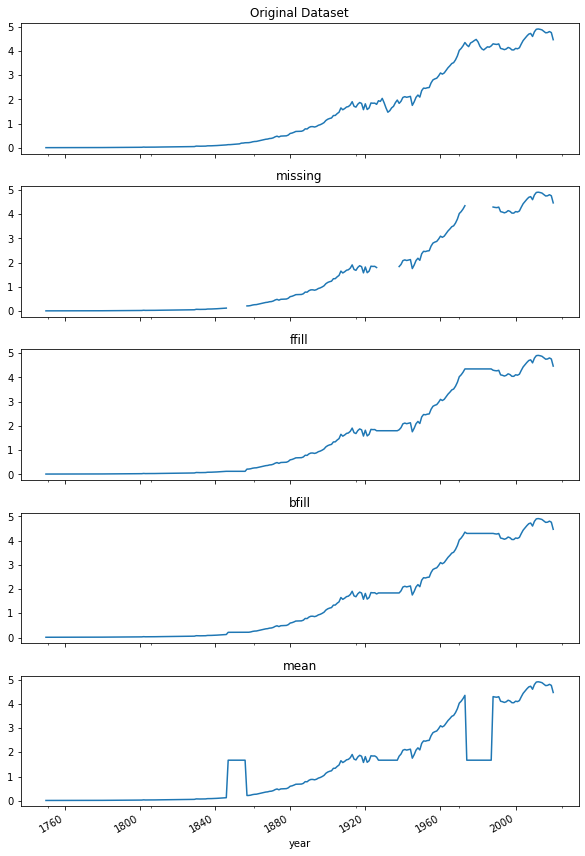

In [61]:
plot_dfs(co2_original, co2_missing, 'co2')

Compare the results in with the original data. Notice that 
both `ffill` and `bfill` produce **better results** than when using the **mean**. Both 
techniques have **favorable RMSE scores** and visual representation

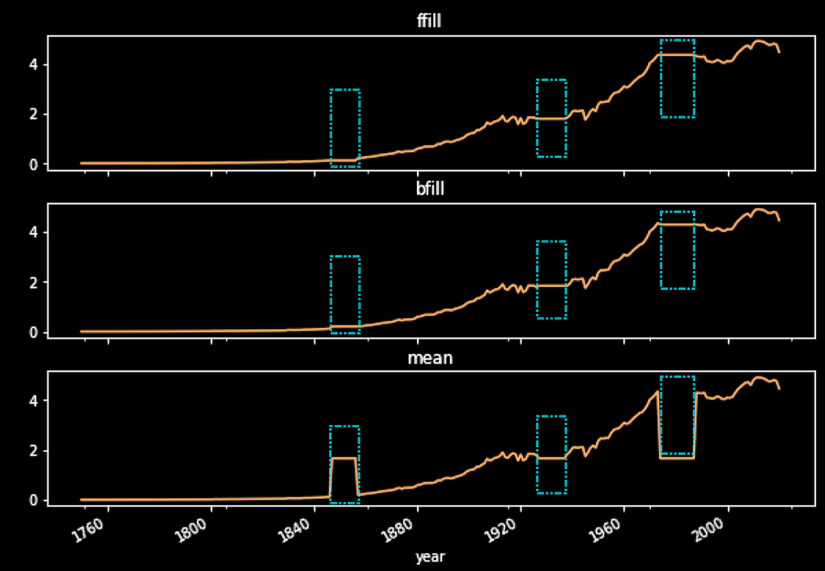

Now, perform the same imputation methods on the Clickstream DataFrame:

In [62]:
clicks_missing['ffil'] = clicks_missing['clicks'].fillna(method='ffill')
clicks_missing['bfill'] = clicks_missing['clicks'].fillna(method='bfill')
clicks_missing['mean'] = clicks_missing['clicks'].fillna(clicks_missing['clicks'].mean())

In [63]:
_ = rmse_score(clicks_original, 
                    clicks_missing, 
                    'clicks')

RMSE for ffil: 1034.1210689204554
RMSE for bfill: 2116.6840489225033
RMSE for mean: 997.7600138929953


Interestingly, for the Clickstream dataset, the mean imputation had the lowest 
RMSE score, in contrast to the results from the CO2 dataset. Let's visualize the 
results to get another perspective on performance:

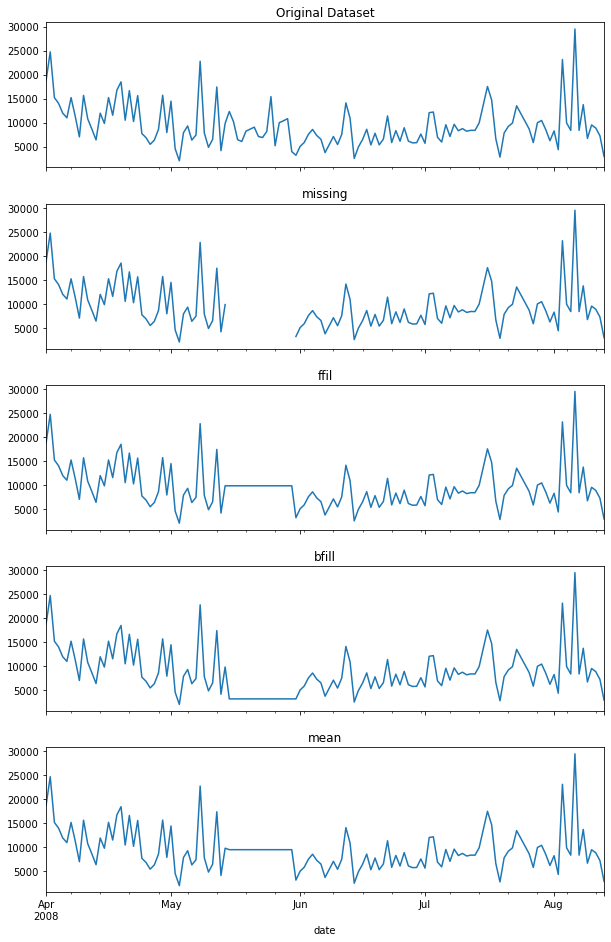

In [64]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

Notice 
that from imputing two different datasets (CO2 and Clickstream), there is no 
one-size-fits-all strategy when it comes to handling missing data. Instead, each 
dataset requires a different strategy. 

Therefore, you should always inspect your 
results and align the outputs with the expectations based on the nature 
of your data

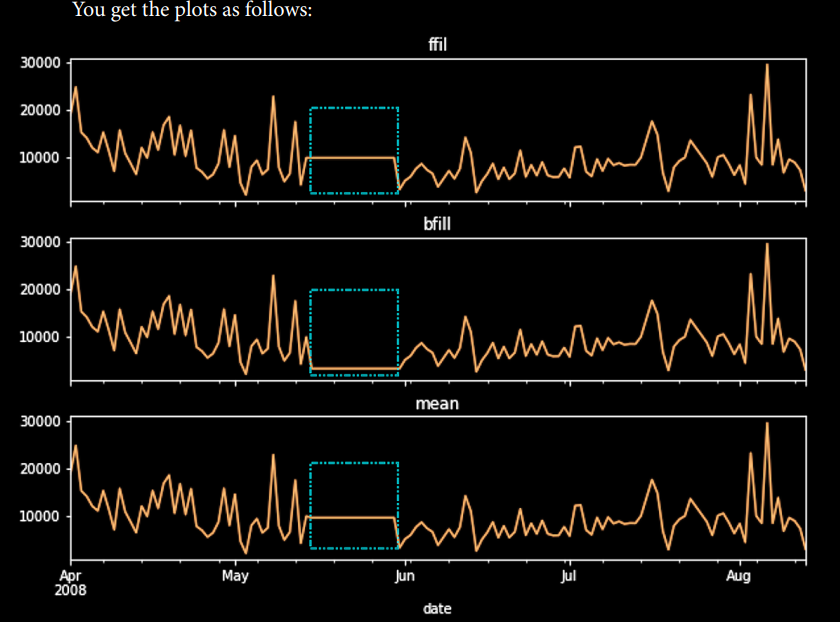

### How it works…
Using `DataFrame.fillna()` is the simplest imputation method. The function can be used in two ways depending on which parameter you are using:
* The `value` parameter, where you can pass a scalar value (numeric or string) to use to fill for all missing values
* The `method` parameter, which takes specific string values: 
 Backward filling: `backfill` or `bfill`, uses the next observation, after the 
missing spot(s) and fills the gaps backward
* Forward filling: `ffill` or `pad`, uses the last value before the missing spot(s) 
and fills the gaps forward.
* Shortcut:
`DataFrame.fillna(method="ffill")` == `DataFrame.ffill()`

In [65]:
co2_missing['co2'].ffill()
co2_missing['co2'].bfill()
clicks_missing['clicks'].ffill()
clicks_missing['clicks'].bfill()

date
2008-04-01    18784.0
2008-04-02    24738.0
2008-04-03    15209.0
2008-04-04    14018.0
2008-04-05    11974.0
               ...   
2008-08-09     6716.0
2008-08-10     9523.0
2008-08-11     8881.0
2008-08-12     7272.0
2008-08-13     2922.0
Name: clicks, Length: 135, dtype: float64

These shortcuts can be convenient when testing different imputation strategies. 


In [66]:
clicks_missing.head()

,price,location,clicks,ffil,bfill,mean
date,,,,,,
2008-04-01,43.155647,2,18784.0,18784.0,18784.0,18784.0
2008-04-02,43.079056,1,24738.0,24738.0,24738.0,24738.0
2008-04-03,43.842609,2,15209.0,15209.0,15209.0,15209.0
2008-04-04,43.312376,1,14018.0,14018.0,14018.0,14018.0
2008-04-05,43.941176,1,11974.0,11974.0,11974.0,11974.0


In [67]:
co2_missing.head()

,co2,ffill,bfill,mean
year,,,,
1750-01-01,0.0125,0.0125,0.0125,0.0125
1760-01-01,0.0128,0.0128,0.0128,0.0128
1770-01-01,0.0150,0.0150,0.0150,0.0150
1780-01-01,0.0169,0.0169,0.0169,0.0169
1790-01-01,0.0206,0.0206,0.0206,0.0206


In [54]:
# clicks_missing.loc['2008-05-10':'2008-05-18']
# clicks_missing.loc['2008-05-30':'2008-06-15']
# clicks_missing[clicks_missing['clicks'].isna()]

### Method 3: Handling Missing Data with Univariate Imputation using Scikit-Learn

* Finally, something for ML peeps. `scikit-learn` is a very popular machine learning library in Python. The `scikit-learn` library 
offers a plethora of options for everyday machine learning tasks and algorithms such 
as classification, regression, clustering, dimensionality reduction, model selection, 
and preprocessing. 
* Additionally, the library offers multiple options for univariate and multivariate 
data imputation. 
* Using Sckit-Learn `SimpleImputer`

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
#################
# Using Sckit-Learn `SimpleImputer`
from sklearn.impute import SimpleImputer
###################

You will be using the SimpleImputer class from the scikit-learn library to 
perform univariate imputation:

In [69]:
folder = Path('./data/')

co2_original = read_dataset(folder, 
                            'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date')

`SimpleImputer` accepts different values for the `strategy` parameter, including 
`mean`, `median`, and `most_frequent`. Let's explore all three strategies and see 
how they compare. Create a list of tuples for each method:

In [70]:
strategy = [
    ('Mean Strategy', 'mean'),
    ('Median Strategy', 'median'),
    ('Most Frequent Strategy', 'most_frequent')]

You can loop through the `Strategy` list to apply the different imputation 
strategies. `SimpleImptuer` has a `fit_transform` method. It combines 
two steps into one: fitting to the data `(.fit)`, and then transforming the data 
`(.transform)`. 

Keep in mind that `SimpleImputer` accepts a `NumPy array`, so you will need to 
use the Series.values property followed by the `.reshape(-1, 1)` method 
to create a 2D NumPy array. Simply, what this is doing is transforming the 1D array 
from `.values` of `shape (226, )` to a 2D array of `shape (226, 1)`, which is 
a column vector:

In [71]:
co2_vals = co2_missing['co2'].values.reshape(-1,1)
clicks_vals = clicks_missing['clicks'].values.reshape(-1,1)

for s_name, s in strategy:
    co2_missing[s_name] = (
        SimpleImputer(strategy=s).fit_transform(co2_vals))
    clicks_missing[s_name] = (
        SimpleImputer(strategy=s).fit_transform(clicks_vals))

C:\Users\hp\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stat

Now, both the clicks_missing and co2_missing DataFrames have three 
additional columns, one for each of the imputation strategies implemented.

In [72]:
co2_missing.head()

,co2,Mean Strategy,Median Strategy,Most Frequent Strategy
year,,,,
1750-01-01,0.0125,0.0125,0.0125,0.0125
1760-01-01,0.0128,0.0128,0.0128,0.0128
1770-01-01,0.0150,0.0150,0.0150,0.0150
1780-01-01,0.0169,0.0169,0.0169,0.0169
1790-01-01,0.0206,0.0206,0.0206,0.0206


In [73]:
clicks_missing.head()

,price,location,clicks,Mean Strategy,Median Strategy,Most Frequent Strategy
date,,,,,,
2008-04-01,43.155647,2,18784.0,18784.0,18784.0,18784.0
2008-04-02,43.079056,1,24738.0,24738.0,24738.0,24738.0
2008-04-03,43.842609,2,15209.0,15209.0,15209.0,15209.0
2008-04-04,43.312376,1,14018.0,14018.0,14018.0,14018.0
2008-04-05,43.941176,1,11974.0,11974.0,11974.0,11974.0


Using the rmse_score function, you can now evaluate each strategy. Start with 
the CO2 data. You should get an output like the following:

In [74]:
_ = rmse_score(co2_original, co2_missing, 'co2')

RMSE for Mean Strategy: 0.7156383637041684
RMSE for Median Strategy: 0.8029421606859859
RMSE for Most Frequent Strategy: 1.1245663822743381


For the Clickstream data, you should get an output like the following:


In [75]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for Mean Strategy: 997.7600138929953
RMSE for Median Strategy: 959.3580492530756
RMSE for Most Frequent Strategy: 1097.6425985146868


Notice how the RMSE strategy rankings vary between the two datasets. For 
example, the Mean strategy performed best on the CO2 data, while the Median
strategy did best on the Clickstream data.

Finally, use the plot_dfs function to plot the results. Start with the CO2 dataset:


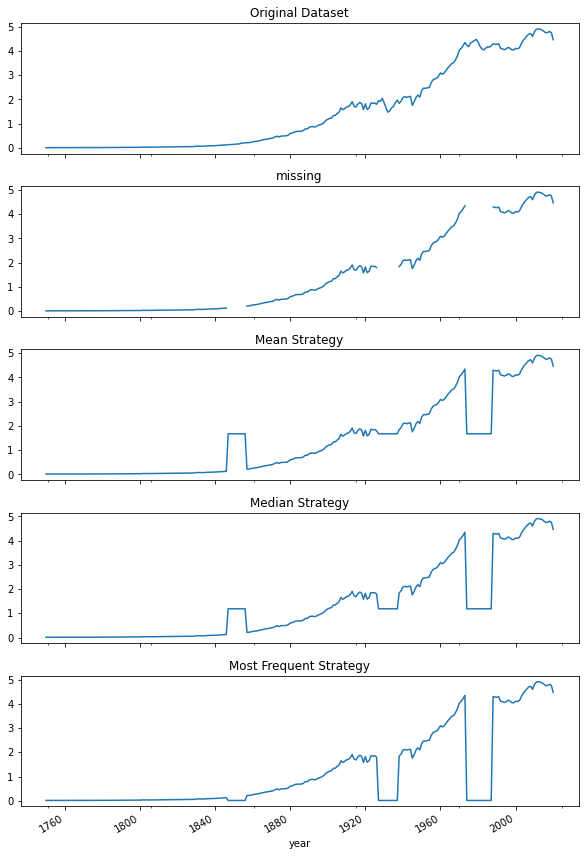

In [76]:
plot_dfs(co2_original, co2_missing, 'co2')

The following plots are produced:
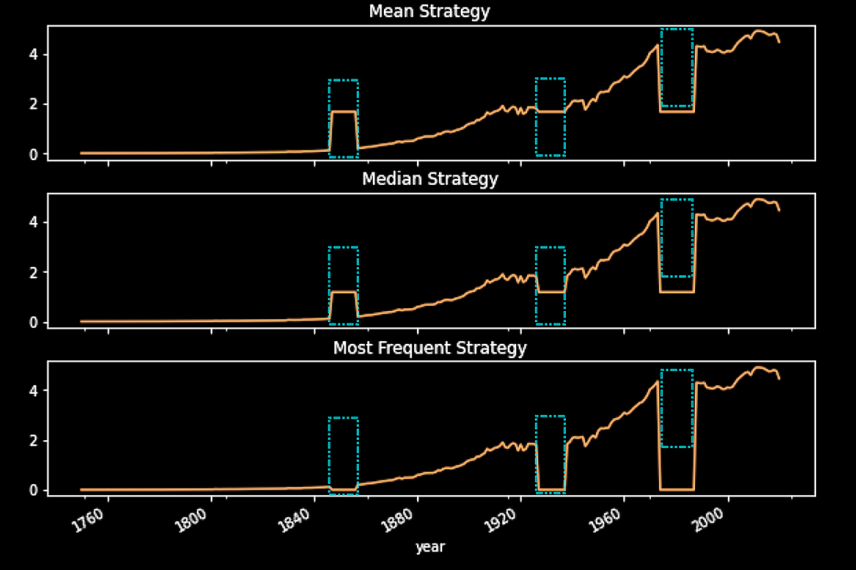

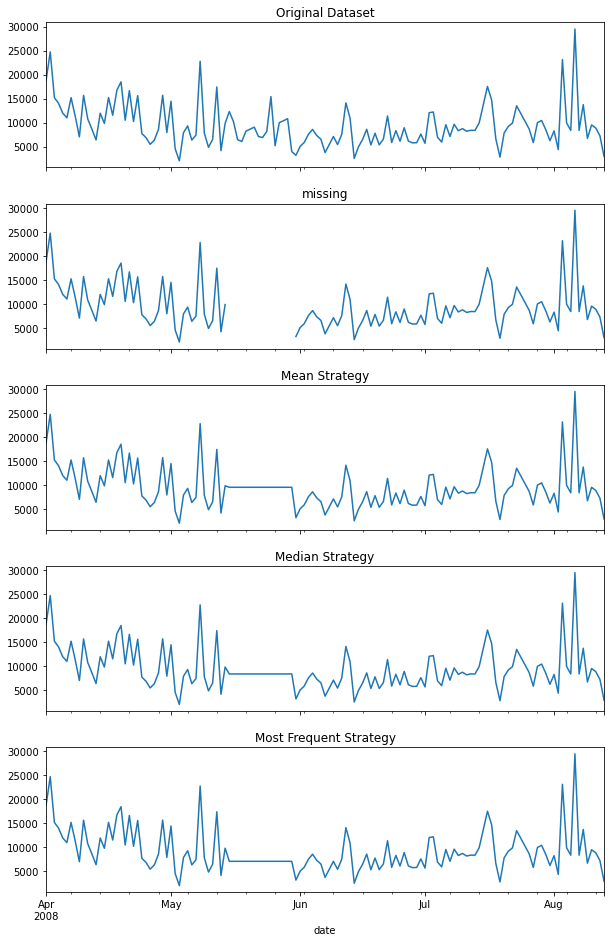

In [77]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

The following plots are produced:
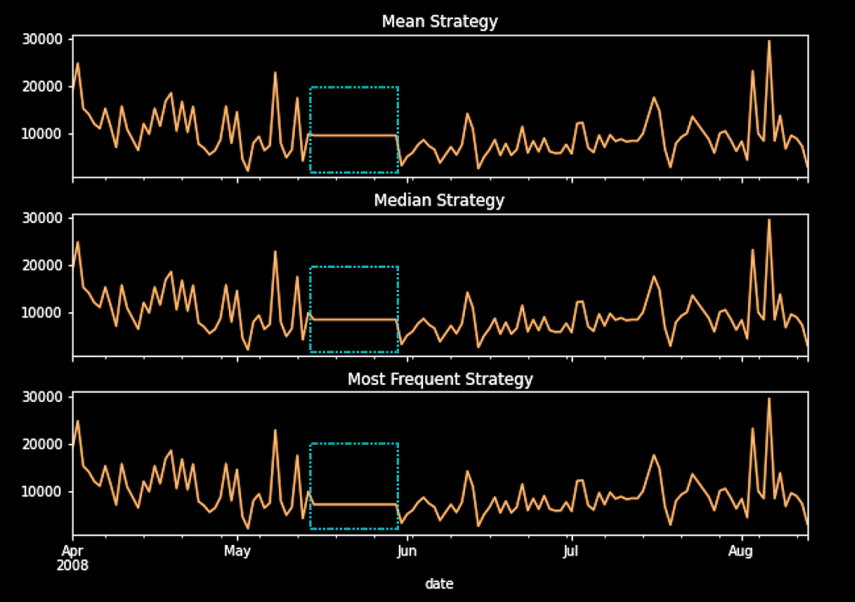

`SimpleImputer` provides basic strategies that may be suitable with some data but not 
others. The advantage of these simple imputation strategies (including the ones from the previous *Handling missing data with univariate imputation using pandas)* method is that 
they are fast and straightforward to implement. 

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

* You used the SimpleImputer class to implement three simple strategies to impute 
missing values: mean, median, and most frequent (mode). 

* This is a univariate imputation technique, meaning only one feature or column was used 
to compute the mean, median, and most frequent value.

* The SimpleImptuer class has three parameters that you need to know:
  * missing_values, which, by default, is set to `nan`, and, more specifically, `np.nan`. NumPy nan and pandas NaN are similar.
  * SimpleImputer will impute all occurrences of the missing_values, which 
you can update with pandas.NA, an integer, float, or a string value.
  *  `strategy`, which defaults to `mean`, and takes `string` values.
  * `fill_value` can be used to replace all instances from `missing_values` with 
a specific value. This can either be a string or a numeric value. If the `Strategy`
was set to `constant`, then you will need to provide your custom `fill_value`.

THERE'S MORE - 
The pandas DataFrame, `.fillna()`, can provide the same functionality 
as `SimpleImputer`. For example, the `mean` strategy can be accomplished by using 
the pandas `DataFrame.mean()` method and passing to `.fillna()`.

In [78]:
avg = co2_missing['co2'].mean()
co2_missing['pands_fillna'] = co2_missing['co2'].fillna(avg)

In [66]:
co2_missing

,co2,Mean Strategy,Median Strategy,Most Frequent Strategy,pands_fillna
year,,,,,
1750-01-01,0.0125,0.0125,0.0125,0.0125,0.0125
1760-01-01,0.0128,0.0128,0.0128,0.0128,0.0128
1770-01-01,0.0150,0.0150,0.0150,0.0150,0.0150
1780-01-01,0.0169,0.0169,0.0169,0.0169,0.0169
1790-01-01,0.0206,0.0206,0.0206,0.0206,0.0206
...,...,...,...,...,...
2016-01-01,4.7496,4.7496,4.7496,4.7496,4.7496
2017-01-01,4.7595,4.7595,4.7595,4.7595,4.7595
2018-01-01,4.8022,4.8022,4.8022,4.8022,4.8022


In [79]:
cols = ['co2', 'Mean Strategy', 'pands_fillna']

_ = rmse_score(co2_original, co2_missing[cols], 'co2')

RMSE for Mean Strategy: 0.7156383637041684
RMSE for pands_fillna: 0.7156383637041684


Notice how you were able to accomplish the same results as the `SimpleImputer` class 
from `scikit-learn`. The `.fillna()` method makes it easier to scale the imputation across 
the entire DataFrame (column by column).

# Method 4: Handling Missing Data with Multivariate Imputation

* Earlier, we discussed the fact that there are two approaches to imputing missing data: 
`univariate imputation` and `multivariate imputation`. 
* As you have seen in the previous methods, `univariate imputation` involves using `one 
variable (column)` to substitute for the missing data, disregarding other variables in the 
dataset. Univariate imputation techniques are usually faster and simpler to implement, 
but a multivariate approach may produce better results in most situations.
* Instead of using a `single variable (column)`, in a multivariate imputation, the method uses 
multiple variables within the dataset to impute missing values. The idea is simple: Have 
more variables within the dataset chime in to `improve the predictability of missing values`. 
* In other words, **univariate imputation** methods handle missing values for a particular 
variable in isolation of the entire dataset and just focus on that variable to derive the 
estimates. 
* **In multivariate imputation**, the assumption is that there is some synergy within 
the variables in the dataset, and collectively, they can provide better estimates to fill in for 
the missing values.

* In this method, you will be working with the `Clickstream dataset` since it has additional variables (clicks, price, and location columns) to perform multivariate imputation for clicks.
  * Using Scikit-Learn `IterativeImputer`
  * Using statsmodels `MICE` implementation

In [68]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

We will use `scikit-learn` (obviously :)) for the `multivariate imputation`. The library 
provides the `IterativeImputer` class, which allows you to pass a `regressor` to predict 
the missing values from other variables (columns) within the dataset: 

In [69]:
folder = Path('./data/')

clicks_original = read_dataset(folder, 
                            'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                            'clicks_missing.csv', 'date')

C:\Users\mailt\AppData\Local\Temp\ipykernel_20124\194839749.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(folder / file,
C:\Users\mailt\AppData\Local\Temp\ipykernel_20124\194839749.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(folder / file,


In [70]:
clicks_missing.isna().sum()

price        0
location     0
clicks      16
dtype: int64

With `IterativeImputer`, you can test `different estimators`. So, let's try `different 
regressors` and compare the results. Create a list of the regressors (estimators) to be 
used in `IterativeImputer`:

In [71]:
estimators = [
    ('bayesianRidge', BayesianRidge()),
    ('extra_trees', ExtraTreesRegressor(n_estimators=10)),
    ('bagging', BaggingRegressor(n_estimators=10)),
    ('elastic_net', ElasticNet()),
    ('linear_regression', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=3))
]

* Loop through the estimators and train on the dataset using `.fit()`, thereby 
building different models, and finally apply the imputation using `.transform()` on the variable with missing data. The results of each estimator will be appended 
as a new column to the `clicks_missing` DataFrame so that it can be used for 
scoring and compare the results visually:

In [72]:
clicks_vals = clicks_missing.iloc[:,0:3].values

for e_name, e in estimators:
    est = IterativeImputer(
                random_state=15,
                estimator=e).fit(clicks_vals)
    clicks_missing[e_name] = est.transform(clicks_vals)[: , 2]

c:\Users\mailt\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\mailt\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [73]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 949.4393973455849
RMSE for extra_trees: 1530.940360862734
RMSE for bagging: 1190.6279027533392
RMSE for elastic_net: 945.4075209343101
RMSE for linear_regression: 938.9419831427183
RMSE for knn: 1336.8798392251822


Observe that Bayesian Ridge, ElasticNet, and Linear Regression produce 
similar results.

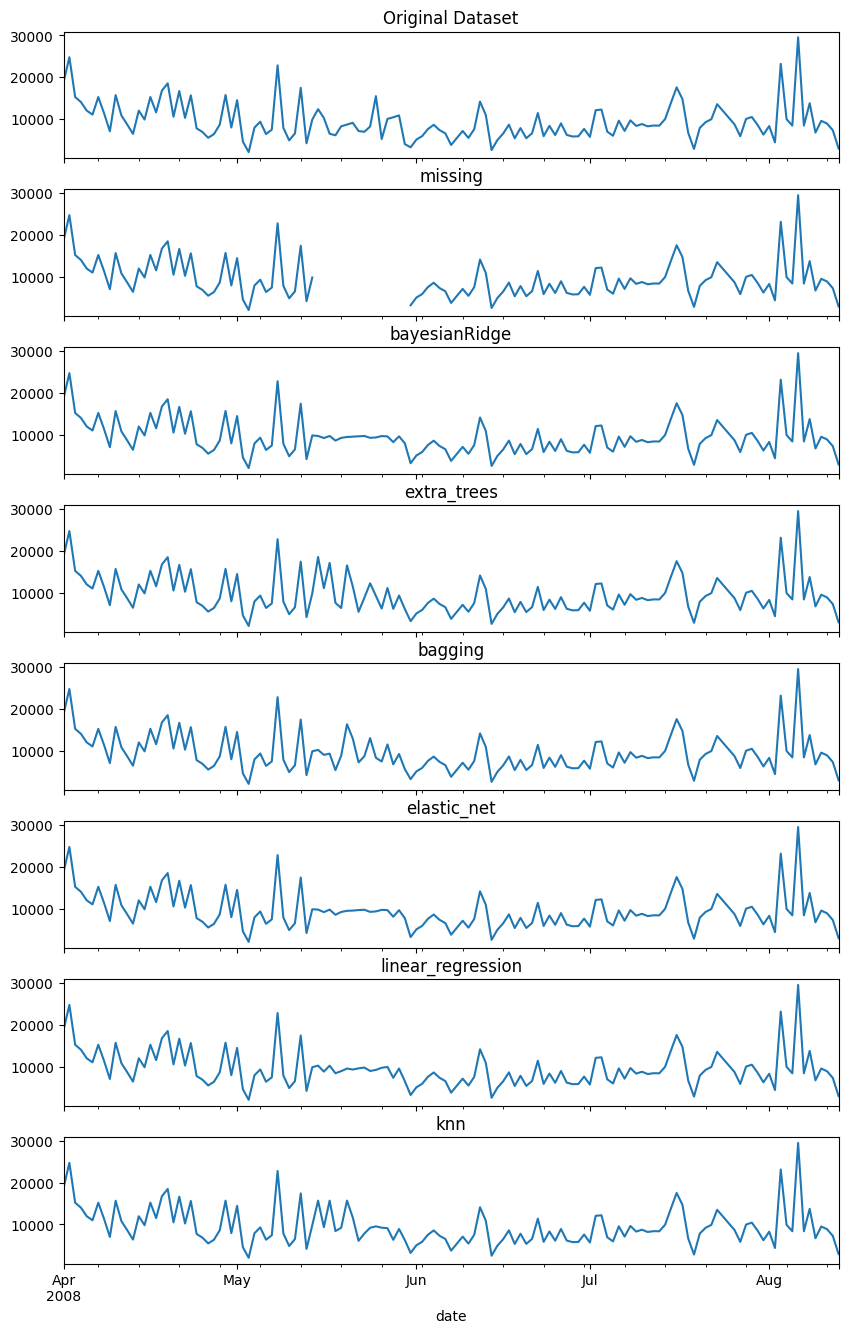

In [74]:

plot_dfs(clicks_original, clicks_missing, 'clicks')

The output is as follows:
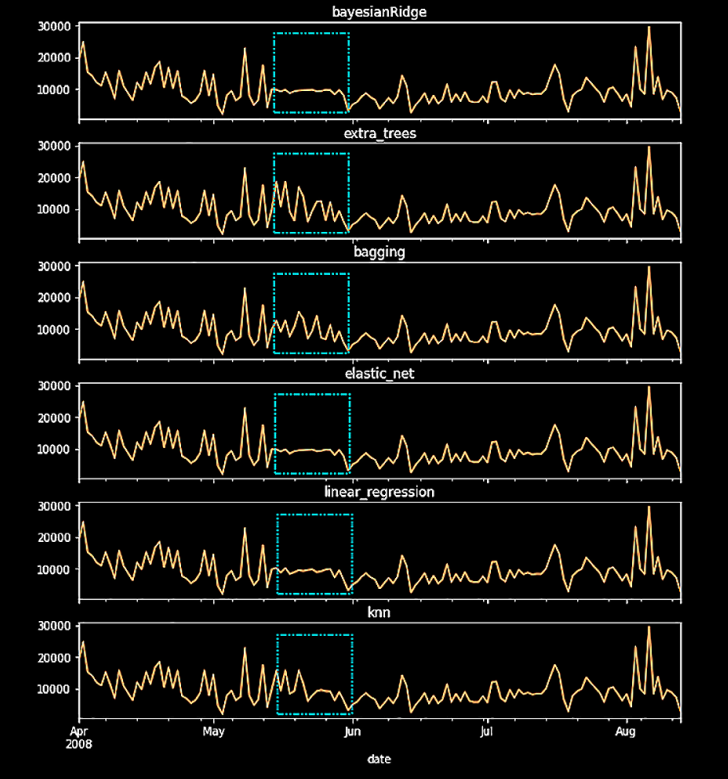

## However, we should note that:
* We noted that the RMSE could be misleading because we did not 
seek the best score (smallest value) since we are not scoring a prediction model but rather an imputation model to fill for missing data. 
* Later, you may use the data (with imputed 
values) to build another model for making predictions (forecasting). Thus, we do not 
mind some imperfections to better resemble real data. 
* Additionally, since we may not 
know the true nature of the missing data, the goal is to get a decent estimate. 
* For example, 
the three with the lowest RMSE scores (BayesianRidge, ElasticNet, and Linear Regression) 
did not capture some of the randomness in the data.

### STATSMODEL MICE IMPLEMENTATION:
"**M**ultivariate **I**mputation by **C**hained **E**quation" - Remember the name.

The `statsmodels `library has an implementation of `MICE` that you can test and 
compare with `IterativeImputer`. This implementation is closer to the `MICE` 
implementation in R, which is why some may call it `R-MICE`.

In [75]:
from statsmodels.imputation.mice import MICE, MICEData, MICEResults
import statsmodels.api as sm

You will use the same DataFrames (clicks_original and clicks_missing) 
and append the statsmodels MICE imputation output to the clicks_missing
DataFrame as an additional column. 

Since your goal is to impute missing data, you can use the `MICEData class` to wrap the 
`clicks_missing DataFrame`. Start by creating an `instance` of `MICEData` and store it in 
a `mice_data variable`

In [76]:
# create a MICEData object
fltr = ['price', 'location','clicks']
mice_data = MICEData(clicks_missing[fltr], 
                     perturbation_method='gaussian')
# 20 iterations
mice_data.update_all(n_iter=20)

mice_data.set_imputer('clicks', formula='~ price + location', model_class=sm.OLS)

Store the results in a new column and call it `MICE`. This way, you can compare the scores with results from IterativeImputer:

In [77]:
clicks_missing['MICE']  = mice_data.data['clicks'].values.tolist()

In [78]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 949.4393973455849
RMSE for extra_trees: 1530.940360862734
RMSE for bagging: 1190.6279027533392
RMSE for elastic_net: 945.4075209343101
RMSE for linear_regression: 938.9419831427183
RMSE for knn: 1336.8798392251822
RMSE for MICE: 2348.4716637753063


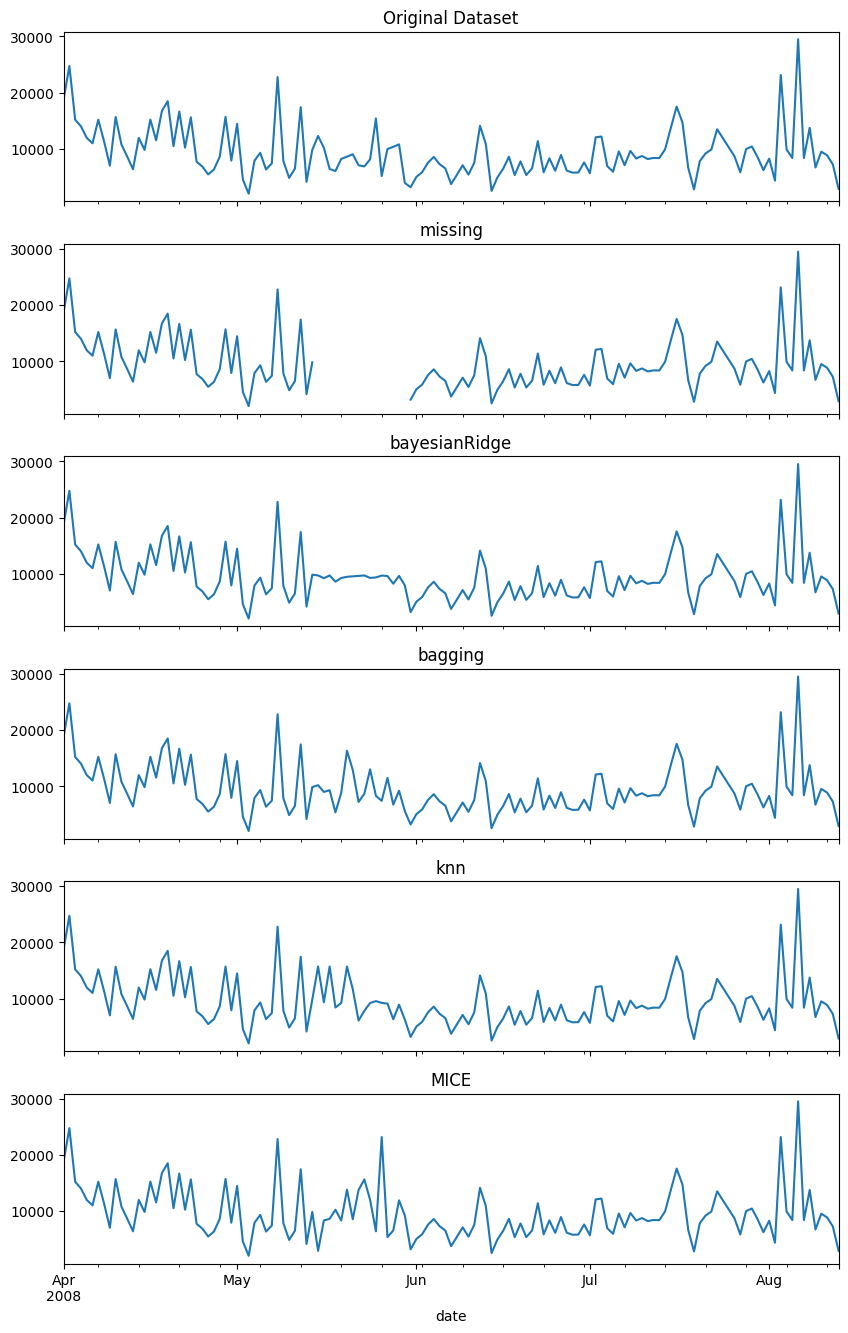

In [79]:
cols = ['clicks','bayesianRidge', 'bagging', 'knn', 'MICE']
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')

Output with a box:
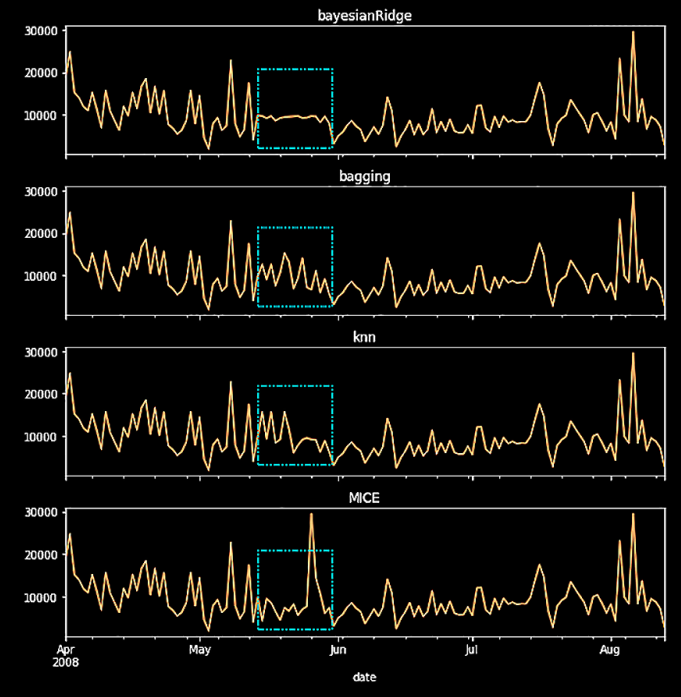

* Overall, multivariate imputation techniques generally produce better results than 
univariate methods. This is true when working with more complex time-series datasets 
in terms of the number of features (columns) and records. 
* Though univariate imputers 
are more efficient in terms of speed and simplicity to interpret, there is a need to balance 
complexity, quality, and analytical requirements. 


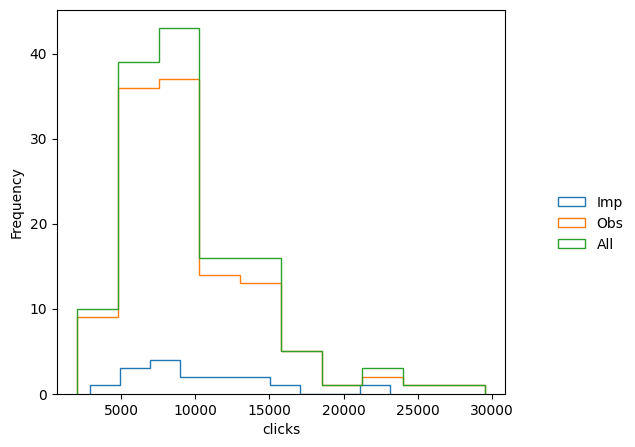

In [80]:
_ = mice_data.plot_imputed_hist('clicks')

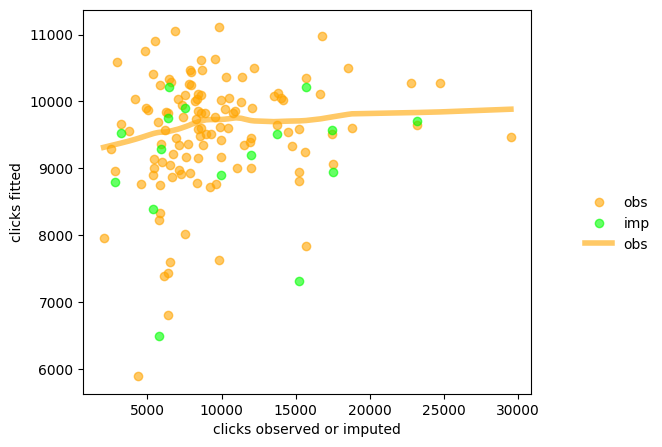

In [81]:
mice_data = MICEData(clicks_missing[fltr], 
                     perturbation_method='gaussian')
mice_data.update_all(n_iter=20)
_ = mice_data.plot_fit_obs('clicks')

* An interesting library, FancyImpute, that originally inspired scikit-learn's 
`IterativeImputer` offers a variety of imputation algorithms that you can check 
out here: https://github.com/iskandr/fancyimpute.

# Method 4: Handling Missing Data with Interpolation

* This for times when someone says 'extrapolate mat kar' - You can 'interpolate'.
* Technique also commonly used for imputing missing values is interpolation. The pandas library provides the `DataFrame.interpolate()` method for more complex 
univariate imputation strategies.

* In this method, you will use the`.interpolate()` function to examine different interpolation methods, including `linear`, `polynomial`, `quadratic`, `nearest`, and `spline`.

* For example, one of the interpolation methods available is linear interpolation. Linear 
interpolation can be used to impute missing data by drawing a straight line between the 
two points surrounding the missing value (in time series, this means for a missing data 
point, it looks at a prior past value and the next future value to draw a line between them). 

* A polynomial interpolation, on the other hand, will attempt to draw a curved line between 
the two points. Hence, each method will have a different mathematical operation to 
determine how to fill in for the missing data. 

In [82]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

Note: The interpolation capabilities in pandas can be extended further through the SciPy
library, which offers additional univariate and multivariate interpolations. But we'll leave that to only those who are interested enough to google-search it up!

In [83]:
folder = Path('./data/')

co2_original = read_dataset(folder, 
                            'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 
                           'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 
                               'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 
                              'clicks_missing.csv', 'date')

C:\Users\mailt\AppData\Local\Temp\ipykernel_20124\194839749.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(folder / file,
C:\Users\mailt\AppData\Local\Temp\ipykernel_20124\194839749.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(folder / file,


In [84]:
co2_missing.interpolate()

,co2
year,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206
...,...
2016-01-01,4.7496
2017-01-01,4.7595
2018-01-01,4.8022


* Create a list of the interpolation methods to be tested: linear, quadratic, 
nearest, and cubic.
* You will loop through the list to run different interpolations using 
`.interpolate()`. 
* Append a new column for each interpolation output to be 
used for comparison:

In [85]:
interpolations = [
    'linear',
    'quadratic',
    'nearest',
    'cubic'
]

for intp in interpolations:
    co2_missing[intp] = co2_missing['co2'].interpolate(method=intp)
    clicks_missing[intp] = clicks_missing['clicks'].interpolate(method=intp)

co2_missing['spline'] = \
        co2_missing['co2'].interpolate(method='spline', order=3)
clicks_missing['spline'] = \
        clicks_missing['clicks'].interpolate(method='spline',order=3)

co2_missing['polynomial'] = \
        co2_missing['co2'].interpolate(method='polynomial',order=3)
clicks_missing['polynomial'] = \
        clicks_missing['clicks'].interpolate(method='polynomial',order=3)




There are two additional methods that it would be interesting to test: spline and polynomial. To use these methods, you will need to provide an integer value for the order parameter. You can try order = 2 for the spline method, and order = 5 for the polynomial method.

Again checking RMSE:

In [86]:
_ = rmse_score(co2_original, co2_missing, 'co2')

RMSE for linear: 0.05507291327761665
RMSE for quadratic: 0.08367561505614347
RMSE for nearest: 0.05385422309469095
RMSE for cubic: 0.08373627305833133
RMSE for spline: 0.17765043760996152
RMSE for polynomial: 0.08373627305833133


In [87]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for linear: 1329.1448378562811
RMSE for quadratic: 5224.641260626975
RMSE for nearest: 1706.1853705030173
RMSE for cubic: 6199.304875782831
RMSE for spline: 6197.349119678481
RMSE for polynomial: 6199.304875782831


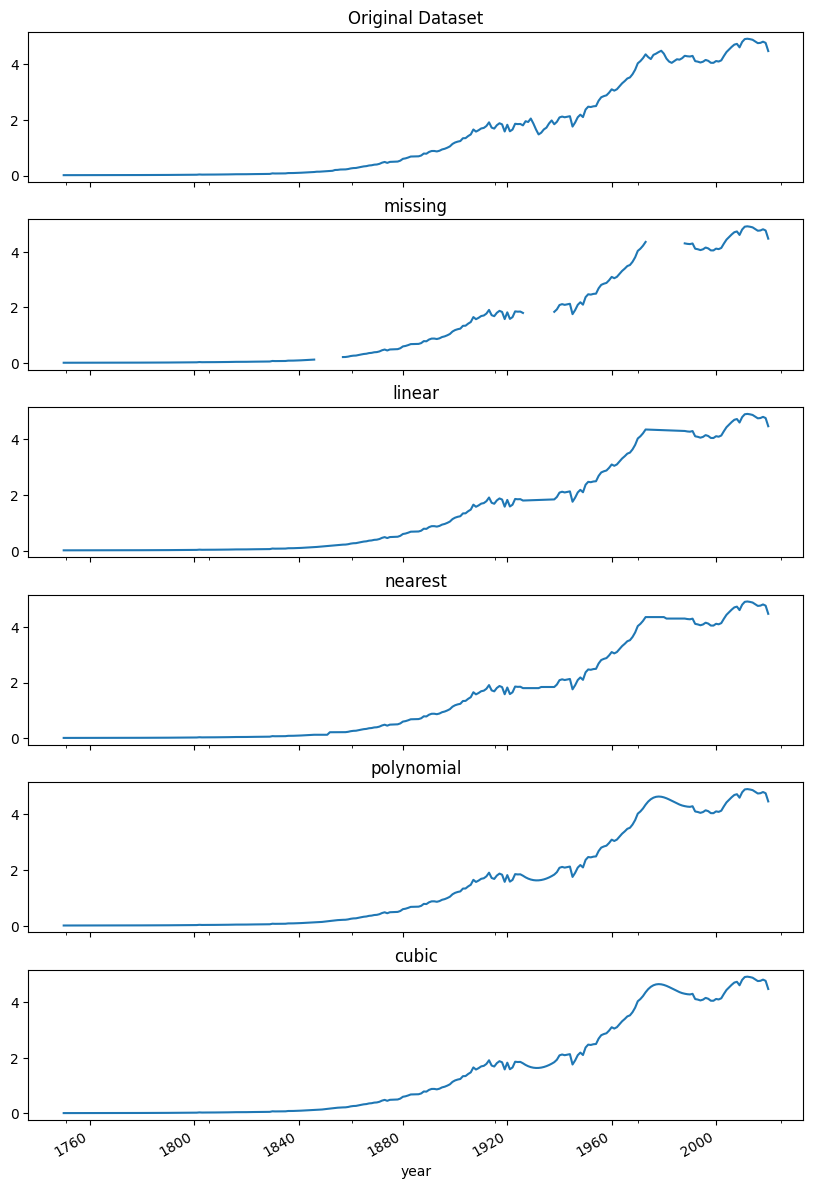

In [88]:
cols = ['co2', 'linear', 'nearest', 'polynomial', 'cubic']
plot_dfs(co2_original, co2_missing[cols], 'co2')

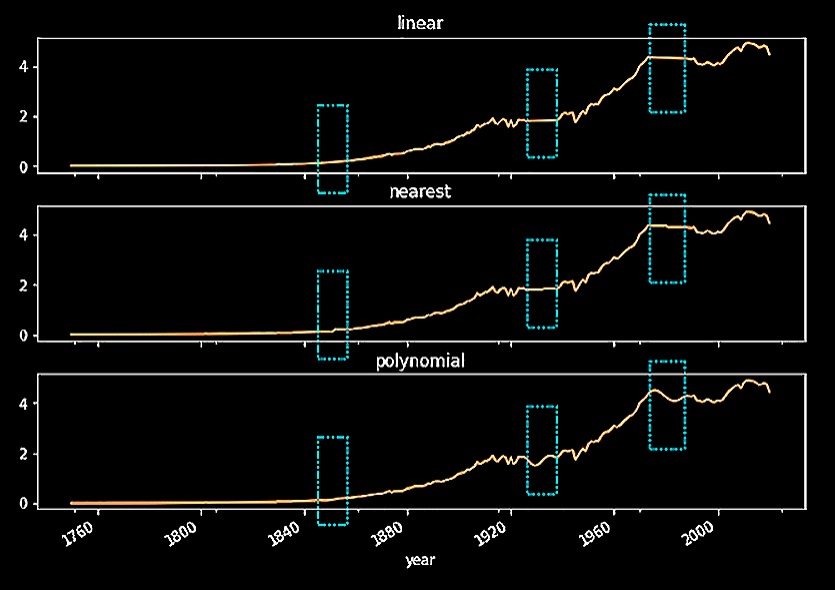
Both the linear and nearest methods seem to have a similar effect regarding 
how the missing values were imputed. This can be seen from the RMSE scores 
and plot.


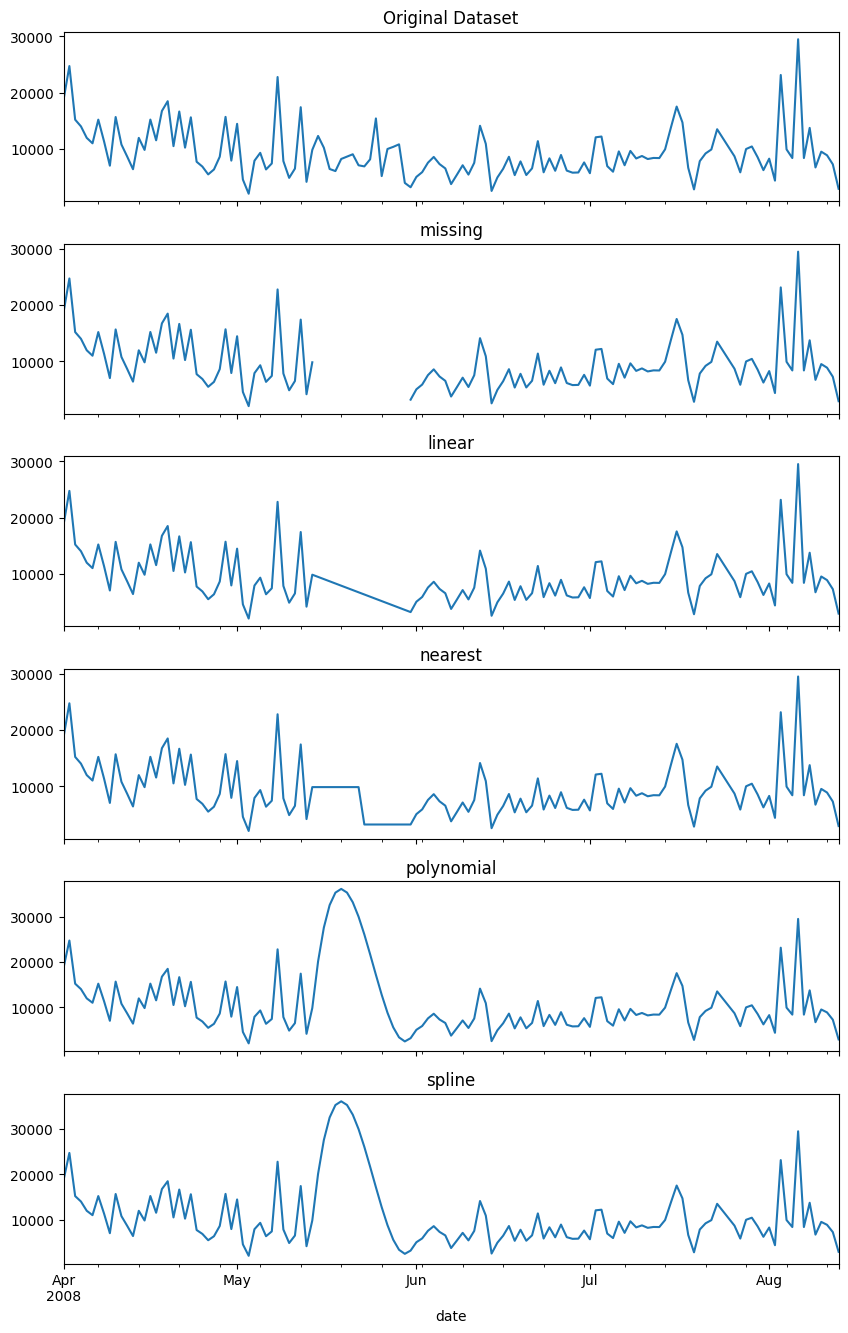

In [89]:
cols = ['clicks', 'linear', 'nearest', 'polynomial', 'spline']
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')

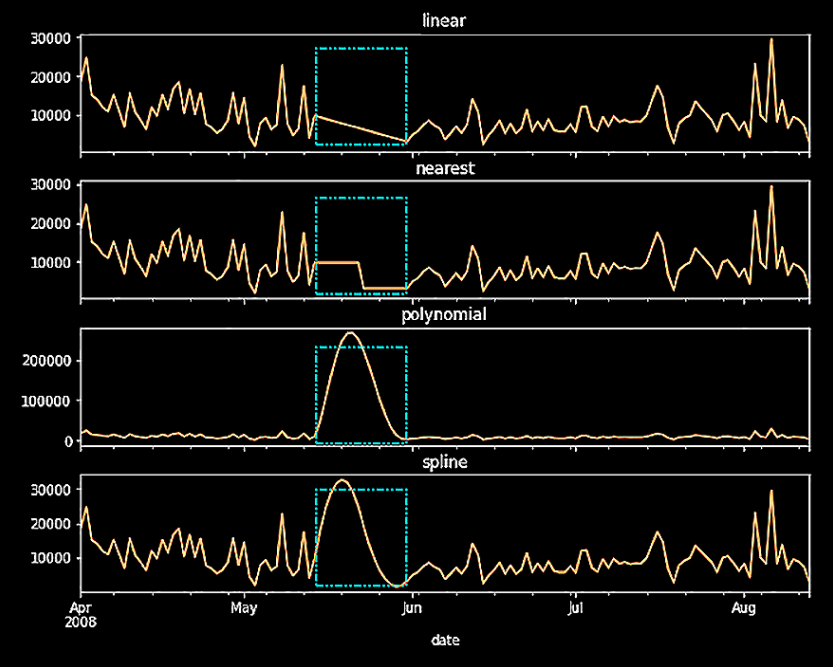
From the output, you can see how the polynomial method exaggerated the curve when 
using 5 as the polynomial order. On the other hand, the Linear method attempts to 
draw a straight line.
One thing to note is that between the strategies implemented, only linear interpolation 
ignores the index, while the rest use numerical values for the index. 



### How it works

* Overall, the interpolation technique detects patterns in neighboring data points (to the 
missing points) to predict what the missing values should be. The simplest form is linear 
interpolation, which assumes a straight line between two neighboring data points. 
* On the other hand, a polynomial defines a curve between the two adjacent data points. 
Each interpolation method uses a different function and mechanism to predict the 
missing data.

In [90]:
clicks_missing['clicks'].isna().sum()

16

In pandas, you will use the `DataFrame.interpolate` function. The default 
interpolation method is the `linear interpolation (method = "linear")`. There 
are additional parameters to provide more control over how the imputation with 
interpolation is done. 

In [91]:
example = clicks_missing['clicks'].interpolate(limit = 5)

The `limit` parameter allows you to set the maximum number of consecutive NaN to 
fill.

In [92]:
example.isna().sum()

11

Only 5 data points were imputed; the remaining 11 were not. 


In [93]:
clicks_missing['clicks']['2008-05-14':]

date
2008-05-14    9841.0
2008-05-15       NaN
2008-05-16       NaN
2008-05-17       NaN
2008-05-18       NaN
               ...  
2008-08-09    6716.0
2008-08-10    9523.0
2008-08-11    8881.0
2008-08-12    7272.0
2008-08-13    2922.0
Name: clicks, Length: 92, dtype: float64

In [94]:
example['2008-05-14':]

date
2008-05-14    9841.0
2008-05-15    9450.0
2008-05-16    9059.0
2008-05-17    8668.0
2008-05-18    8277.0
               ...  
2008-08-09    6716.0
2008-08-10    9523.0
2008-08-11    8881.0
2008-08-12    7272.0
2008-08-13    2922.0
Name: clicks, Length: 92, dtype: float64

HW: Learn More about KNNImputer 
```
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
knnimp_df = imputer.fit_transform(dfmiss)
```